In [71]:
# LB1
import datetime
from datetime import date
import key

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
from matplotlib import pyplot as plt

from fredapi import Fred
fred = Fred(api_key=key.FED_KEY)

pd.options.display.float_format = "{:,.3f}".format
yfin.pdr_override()

In [72]:
# IP1: Pulling data from Yahoo

start = '2022-06-28'
end = '2023-06-28'
asset = web.DataReader(["META","^SP500-60"], start, end)["Adj Close"]
asset[['META', '^SP500-60']] = asset[['META', '^SP500-60']].ffill()
asset.reset_index()

[*********************100%***********************]  2 of 2 completed


,Date,META,^SP500-60
0,2022-06-28,160.680,257.650
1,2022-06-29,163.940,255.690
2,2022-06-30,161.250,255.770
3,2022-07-01,160.030,260.530
4,2022-07-05,168.190,259.250
...,...,...,...
246,2023-06-21,281.640,230.610
247,2023-06-22,284.880,227.230
248,2023-06-23,288.730,224.600
249,2023-06-26,278.470,229.780


In [73]:
# Pulling Fed Rate
start = '2022-06-28'
end = '2023-06-27'

fed_effective_rate = pd.DataFrame(fred.get_series(
    'RIFSPFFNB',
    observation_start=start,
    observation_end=end)).resample("D").mean()
fed_effective_rate.columns = ['Rate']
fed_effective_rate = fed_effective_rate.ffill()

In [74]:
df = asset.join(fed_effective_rate, lsuffix="_left")
df.rename(columns = {'META' : 'Equity: Meta', '^SP500-60': 'Real Estate', 'Rate' : 'Interest rate'}, inplace = True)

In [75]:
df.describe()

,Equity: Meta,Real Estate,Interest rate
count,251.000,251.000,251.000
mean,172.354,241.898,3.783
std,49.173,16.664,1.138
min,88.910,211.450,1.580
25%,133.340,230.355,3.080
50%,167.110,236.280,4.330
75%,205.140,253.140,4.830
max,288.730,286.330,5.080


In [76]:
df_asset = df[['Equity: Meta', 'Real Estate']]
df_return = np.log(df_asset) - np.log(df_asset.shift(1))
df_return = df_return.iloc[1:, 0:]
df_return

,Equity: Meta,Real Estate
Date,,
2022-06-29,0.020,-0.008
2022-06-30,-0.017,0.000
2022-07-01,-0.008,0.018
2022-07-05,0.050,-0.005
2022-07-06,0.009,0.000
...,...,...
2023-06-21,-0.010,-0.006
2023-06-22,0.011,-0.015
2023-06-23,0.013,-0.012


In [77]:
# VL1: Calculate simple volatility in dataset with max - min
# (currYear.max() - currYear.min()) / prices.iloc[-1]
(df.max() - df.min())/ df.iloc[-1]

Equity: Meta    0.696
Real Estate     0.323
Interest rate   0.690
dtype: float64

In [78]:
# # MA1: Set rolling average, then plot it
# df["Equity: Meta Rolling Average"] = df['Equity: Meta'].rolling(50).mean()

# # set figure size
# plt.figure(figsize=(12, 5))

# # plot a simple time series plot using seaborn.lineplot()
# sns.lineplot(x=df.index, y="Equity: Meta", data=df, label="Equity: Meta")

# # plot rolling average
# sns.lineplot(x=df.index, y="Equity: Meta Rolling Average", data=df, label="Equity Rolling Avg");

In [79]:
((abs(df - df.rolling(50).mean())) / df).mean()

Equity: Meta    0.148
Real Estate     0.047
Interest rate   0.091
dtype: float64

<Axes: xlabel='Date'>

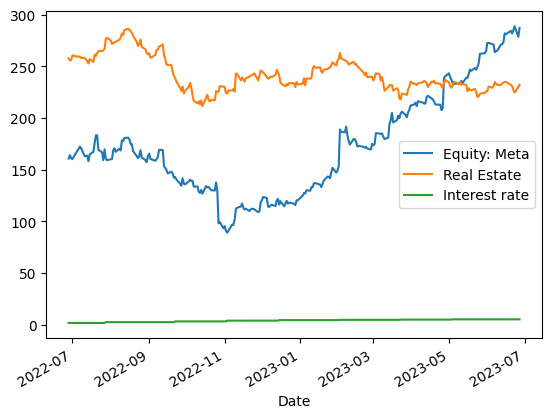

In [80]:
# Plotting data
df.plot()

In [81]:
# IP5: Covariance Matrix
df.cov()

,Equity: Meta,Real Estate,Interest rate
Equity: Meta,"2,417.946",-100.463,26.676
Real Estate,-100.463,277.677,-11.540
Interest rate,26.676,-11.540,1.296


In [82]:
# IP6: Pearson Correlation Coeffcient Matrix
round(df.corr(), 3)

,Equity: Meta,Real Estate,Interest rate
Equity: Meta,1.000,-0.123,0.477
Real Estate,-0.123,1.000,-0.608
Interest rate,0.477,-0.608,1.000


<Axes: xlabel='Interest rate', ylabel='Equity: Meta'>

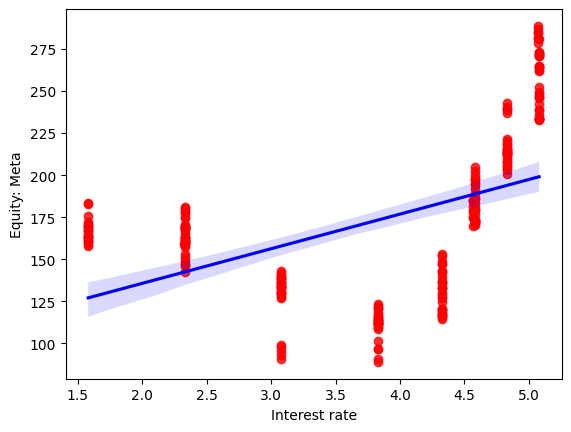

In [83]:
sns.regplot(
    x=df['Interest rate'], 
    y=df['Equity: Meta'],
    data=df,
    scatter_kws = {"color" : "red"},
    line_kws = {"color" : "blue"}
    )

The correlation between Equity and Interest rate is slightly positive, 0.477.
It means when the interest rate increase, it will slightly increase META price.

<Axes: xlabel='Interest rate', ylabel='Real Estate'>

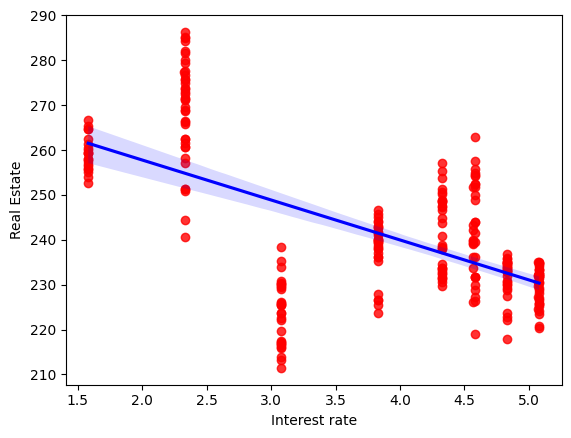

In [84]:
sns.regplot(
    x=df['Interest rate'], 
    y=df['Real Estate'],
    data=df,
    scatter_kws = {"color" : "red"},
    line_kws = {"color" : "blue"}
    )

In contrast, the Real Estate price has slight negative correlation with interest rate.
Means when the interest rate increase, the real estate price will slightly decrease.

In [85]:
df.std()

Equity: Meta    49.173
Real Estate     16.664
Interest rate    1.138
dtype: float64

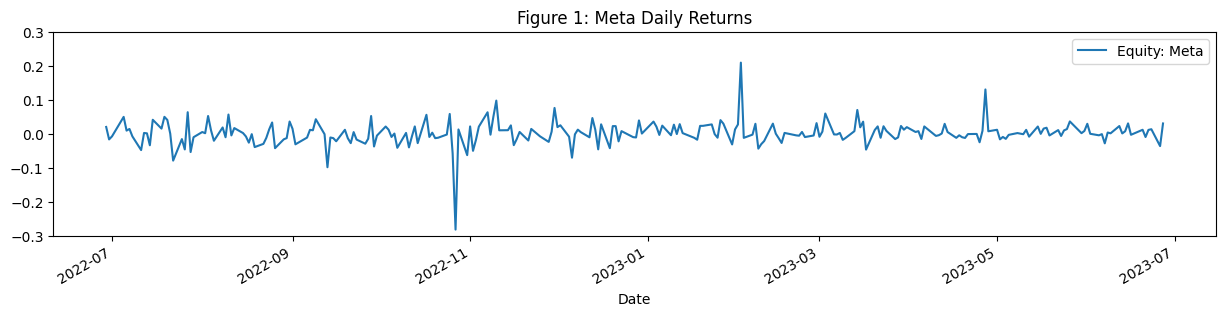

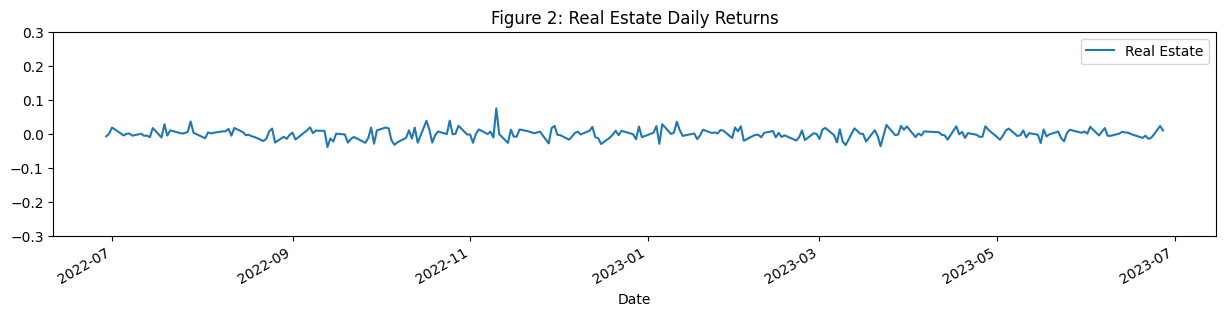

In [86]:
ax1 = df_return.plot(figsize=(15, 3), y="Equity: Meta", title="Figure 1: Meta Daily Returns")
ax2 = df_return.plot(figsize=(15, 3), y="Real Estate", title="Figure 2: Real Estate Daily Returns")

ax1.set_ylim(-0.3, 0.3)
ax2.set_ylim(-0.3, 0.3);

In [87]:
equitymean = df_return["Equity: Meta"].mean()
equity_semivariance = ((df_return[df_return["Equity: Meta"] < equitymean]["Equity: Meta"] - equitymean) ** 2).mean()
equity_semivariance

0.0012674479741085183

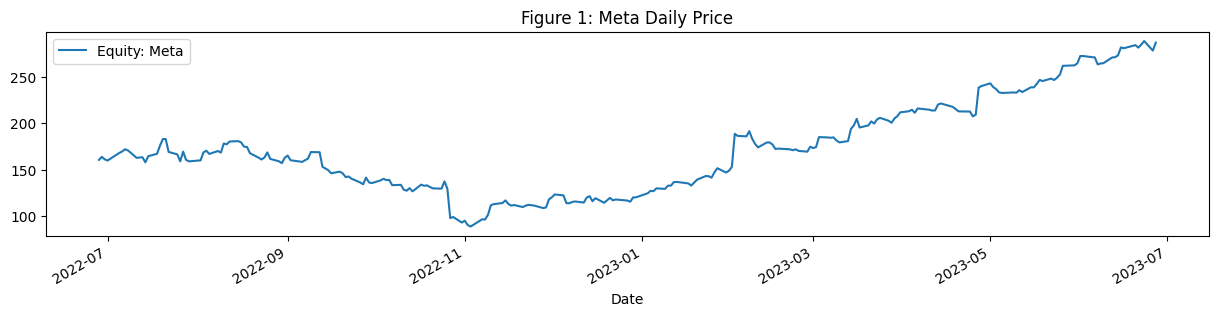

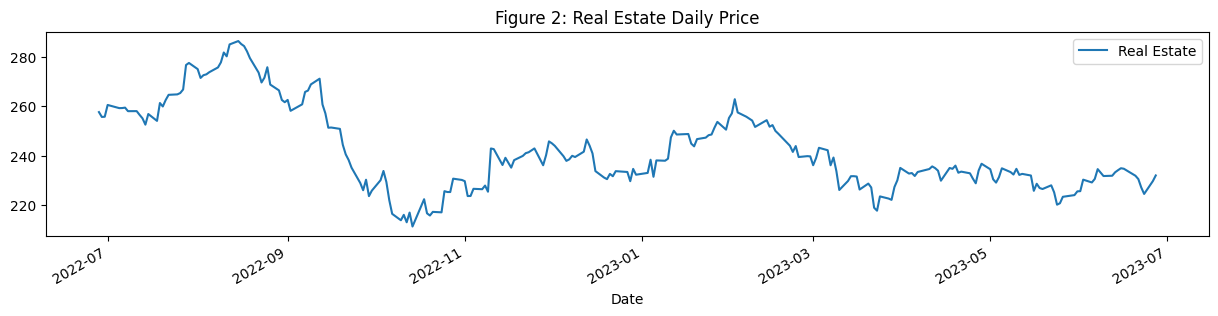

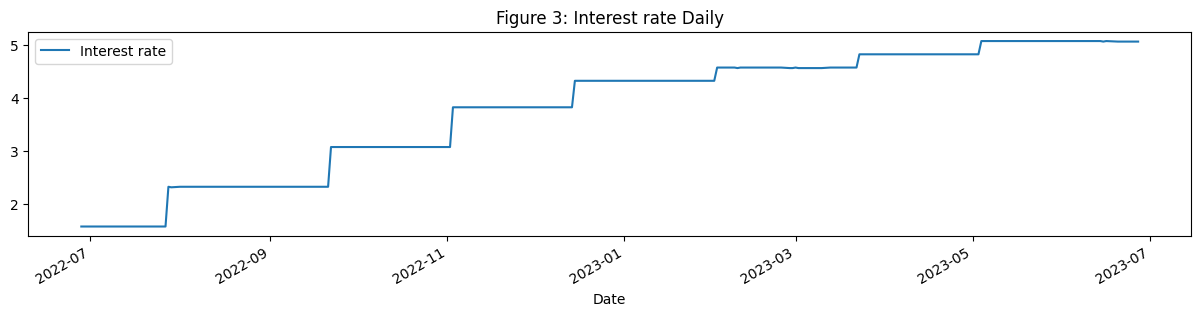

In [88]:
ax1 = df.plot(figsize=(15, 3), y="Equity: Meta", title="Figure 1: Meta Daily Price")
ax2 = df.plot(figsize=(15, 3), y="Real Estate", title="Figure 2: Real Estate Daily Price")
ax3 = df.plot(figsize=(15, 3), y="Interest rate", title="Figure 3: Interest rate Daily")

# ax1.set_ylim(-0.3, 0.3)
# ax2.set_ylim(-0.3, 0.3);

The above charts clearly show the trends of 3 data series

In [1]:
jupyter nbconvert --to html M3-Project 1-GWP.ipynb

SyntaxError: invalid syntax (1984753229.py, line 1)